# Import dependencies 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import json, gc, re
import string
import numpy as np
from collections import Counter
import torch
import pickle
from wordcloud import WordCloud, STOPWORDS
from textwrap import wrap
import torch.nn as nn
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from transformers import BertModel, BertTokenizer
cyberbullying_path = "/kaggle/input/gsoc-dataset/"

# Feature Engineering

In [2]:
#load twitter racism dataset
data = pd.read_csv(cyberbullying_path+"twitter_racism_parsed_dataset.csv", encoding='utf8', index_col=False)
lengths=[]
puncs=[]
num_ats=[]
num_hashs=[]
for i in range(len(data)):
    punc=0
    ats=0
    hashs=0
    row = data.iloc[i,:]
    text = str(row['Text'])
    for i in text:
        if (i in string.punctuation):
            punc+=1
        if (i=='@'):
            ats+=1
        if (i=='#'):
            hashs+=1

    length = len(text.split())
    lengths.append(length)
    puncs.append(punc)
    num_ats.append(ats)
    num_hashs.append(hashs)

data['length'] = lengths
data['punc'] = puncs
data['num_mentions'] = num_ats
data['num_hashtags'] = num_hashs

In [3]:
data.head()

,index,id,Text,Annotation,oh_label,length,punc,num_mentions,num_hashtags
0,5.767493e+17,5.767493e+17,@AAlwuhaib1977 Muslim mob violence against Hin...,racism,1,13,8,1,1
1,5.408905e+17,5.408905e+17,@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG,none,0,2,7,1,0
2,5.678433e+17,5.678433e+17,@jncatron @isra_jourisra @AMPalestine Islamoph...,racism,1,21,6,3,0
3,5.766462e+17,5.766462e+17,"Finally I'm all caught up, and that sudden dea...",none,0,18,4,0,1
4,5.713492e+17,5.713492e+17,@carolinesinders @herecomesfran *hugs*,none,0,3,4,2,0


In [4]:
#visualize dataset
print("NULL values :")
print(data.isnull().sum())
print("\nLength of dataset : ", len(data))
print("\nvalue counts of",data['oh_label'].value_counts())
data.dropna(subset=data.columns, inplace=True)

NULL values :
index           0
id              0
Text            0
Annotation      0
oh_label        0
length          0
punc            0
num_mentions    0
num_hashtags    0
dtype: int64

Length of dataset :  13471

value counts of oh_label
0    11501
1     1970
Name: count, dtype: int64


In [5]:
#separate data
ham = data[data['oh_label']==0]
spam = data[data['oh_label']==1]

In [6]:
#balance the data
ham = ham.sample(spam.shape[0])
ham.shape, spam.shape

((1970, 9), (1970, 9))

In [7]:
#merge and shuffle data
balanced_data = pd.concat([ham, spam], ignore_index=True)
balanced_data = balanced_data.sample(frac=1).reset_index(drop=True)

In [8]:
balanced_data.head()

,index,id,Text,Annotation,oh_label,length,punc,num_mentions,num_hashtags
0,5.761510e+17,5.761510e+17,@JWYoder ouch.,none,0,2,2,1,0
1,5.747635e+17,5.747635e+17,@ardiem1m @Alfonso_AraujoG @MaxBlumenthal @old...,none,0,20,8,4,0
2,5.046794e+17,5.046794e+17,"#twosecondcomebacks ""You're too sensitive."" ""N...",none,0,9,10,0,1
3,5.685417e+17,5.685417e+17,@buellerishere Who cares. ISIS does what Moham...,racism,1,20,10,1,0
4,5.684389e+17,5.684389e+17,yessssssss http://t.co/Td90k9Ik2r,none,0,2,5,0,0


# Data Cleaning and preprocessing

In [9]:
#data cleaning
balanced_data['cleaned']=balanced_data['Text'].apply(lambda x: x.lower())
balanced_data['cleaned']=balanced_data['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))
balanced_data['cleaned']=balanced_data['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
balanced_data['cleaned']=balanced_data['cleaned'].apply(lambda x: re.sub(' +',' ',x))

In [10]:
#declarations
tokenizer = RegexpTokenizer(r'[A-Za-z0-9]+')
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english')
def join(l):
    f=''
    for i in l:
        f+=str(i)+' '
    return str(f)

def one_hot(labels, classes=2):
    new = np.zeros((len(labels), classes))
    for i in range(len(labels)):
        new[i, int(labels[i])]=1
        
    return new

In [11]:
#tokenization and stemming
tokenized_text = [tokenizer.tokenize(str(x)) for x in balanced_data['cleaned']]
stemmed_text=[]
for i in range(len(tokenized_text)):
    l = [stemmer.stem(word) for word in tokenized_text[i]]
    stemmed_text.append(l)
    
final_text=[join(st) for st in stemmed_text]
balanced_data['Final_text']=final_text

# Exploratory Data Analysis

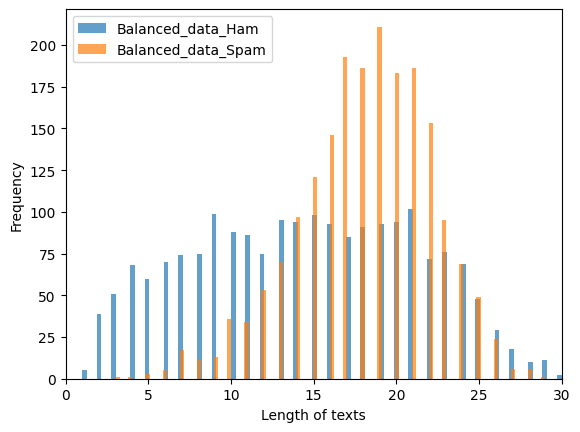

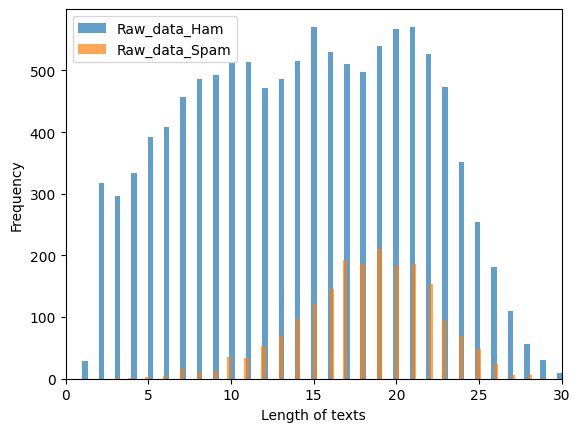

In [12]:
#histograms
plt.hist(balanced_data[balanced_data['oh_label']==0]['length'], bins=100, alpha=0.7, label='Balanced_data_Ham')
plt.hist(balanced_data[balanced_data['oh_label']==1]['length'], bins=100, alpha=0.7, label='Balanced_data_Spam')
plt.xlabel('Length of texts')
plt.ylabel('Frequency')
plt.legend()
plt.xlim(0,30)
plt.show()

plt.hist(data[data['oh_label']==0]['length'], bins=100, alpha=0.7, label='Raw_data_Ham')
plt.hist(data[data['oh_label']==1]['length'], bins=100, alpha=0.7, label='Raw_data_Spam')
plt.xlabel('Length of texts')
plt.ylabel('Frequency')
plt.legend()
plt.xlim(0,30)
plt.show()

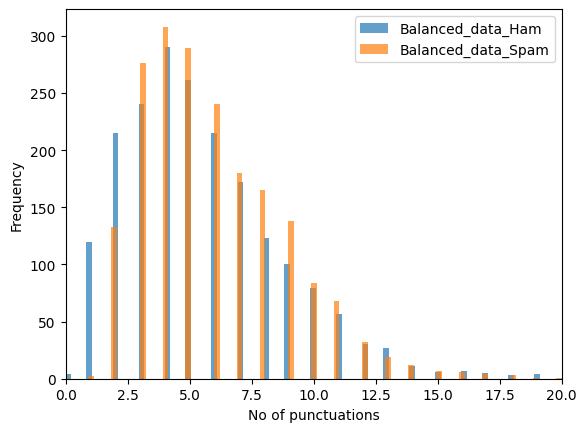

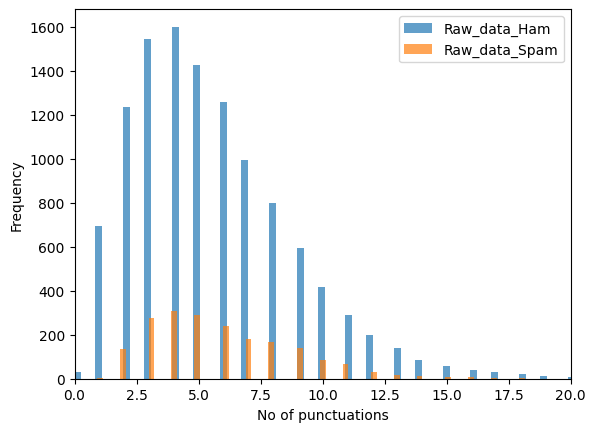

In [13]:
plt.hist(balanced_data[balanced_data['oh_label']==0]['punc'], bins=100, alpha=0.7, label='Balanced_data_Ham')
plt.hist(balanced_data[balanced_data['oh_label']==1]['punc'], bins=100, alpha=0.7, label='Balanced_data_Spam')
plt.xlabel('No of punctuations')
plt.ylabel('Frequency')
plt.legend()
plt.xlim(0,20)
plt.show()

plt.hist(data[data['oh_label']==0]['punc'], bins=100, alpha=0.7, label='Raw_data_Ham')
plt.hist(data[data['oh_label']==1]['punc'], bins=100, alpha=0.7, label='Raw_data_Spam')
plt.xlabel('No of punctuations')
plt.ylabel('Frequency')
plt.legend()
plt.xlim(0,20)
plt.show()

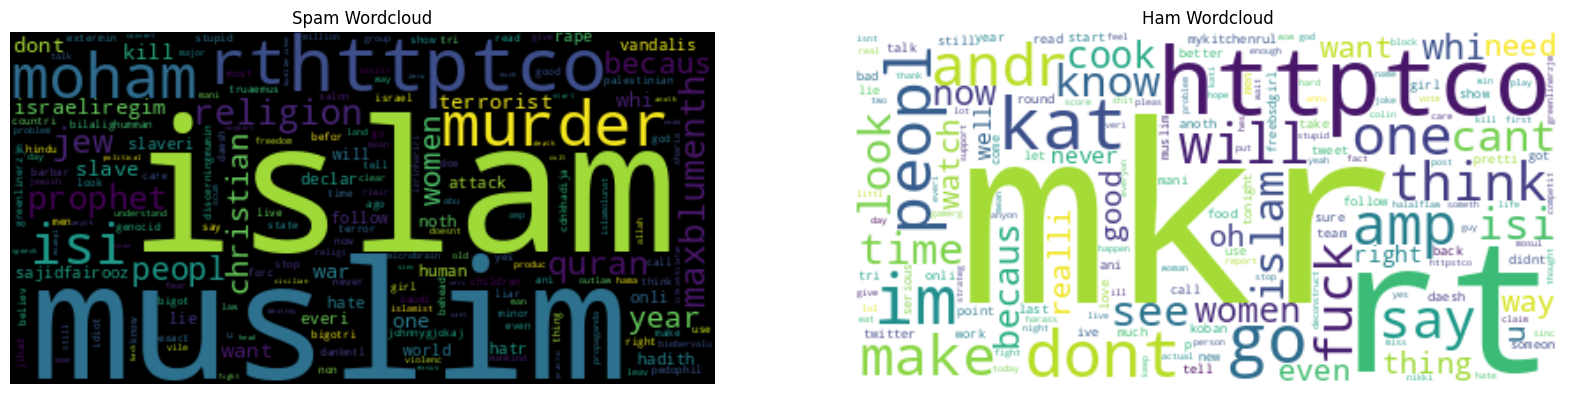

In [14]:
#generate wordclouds
spam_texts = balanced_data[balanced_data['oh_label']==1]['Final_text'].astype('str').values
ham_texts = balanced_data[balanced_data['oh_label']==0]['Final_text'].astype('str').values
spam_words = ''
ham_words=''
stopwords = set(STOPWORDS)
for text in spam_texts:
    spam_words+=" "+text.lower()+" "
    
for text in ham_texts:
    ham_words+=" "+text.lower()+" "
    
    
fig, axs = plt.subplots(1,2 , figsize=(20,20))
spam_wc = WordCloud(collocations = False, background_color = 'black', stopwords = stopwords).generate(spam_words)
ham_wc = WordCloud(collocations = False, background_color = 'white', stopwords = stopwords).generate(ham_words)
axs[0].imshow(spam_wc, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Spam Wordcloud')
axs[1].imshow(ham_wc, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Ham Wordcloud')

plt.show()


<Figure size 600x300 with 0 Axes>

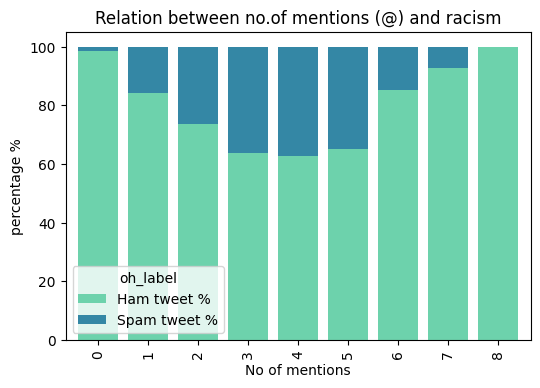

<Figure size 600x300 with 0 Axes>

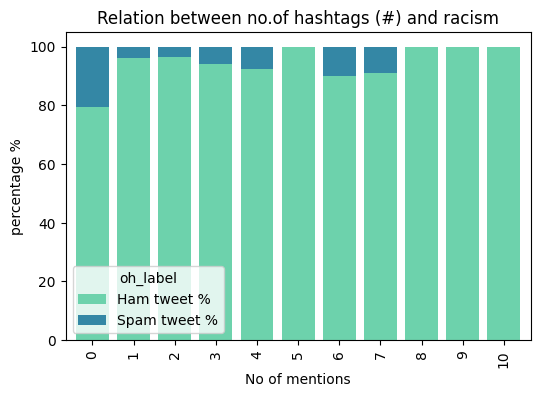

In [15]:
plt.figure(figsize=(6, 3))
mention_label_cross = pd.crosstab(data['num_mentions'], data['oh_label'])
mention_label_cross['sum'] = mention_label_cross[0] + mention_label_cross[1]
mention_label_cross['Ham tweet %'] = mention_label_cross[0]/mention_label_cross['sum']*100
mention_label_cross['Spam tweet %'] = mention_label_cross[1]/mention_label_cross['sum']*100
mention_label_cross = mention_label_cross.drop([0, 1, 'sum'], axis=1)


mention_label_cross.plot(kind='bar', stacked=True, figsize=(6, 4), color=['#6dd2ac', '#3487a5'], width=0.8)
plt.xlabel('No of mentions')
plt.ylabel('percentage %')
plt.title('Relation between no.of mentions (@) and racism')
plt.show()

plt.figure(figsize=(6, 3))
mention_label_cross = pd.crosstab(data['num_hashtags'], data['oh_label'])
mention_label_cross['sum'] = mention_label_cross[0] + mention_label_cross[1]
mention_label_cross['Ham tweet %'] = mention_label_cross[0]/mention_label_cross['sum']*100
mention_label_cross['Spam tweet %'] = mention_label_cross[1]/mention_label_cross['sum']*100
mention_label_cross = mention_label_cross.drop([0, 1, 'sum'], axis=1)


mention_label_cross.plot(kind='bar', stacked=True, figsize=(6, 4), color=['#6dd2ac', '#3487a5'], width=0.8)
plt.xlabel('No of mentions')
plt.ylabel('percentage %')
plt.title('Relation between no.of hashtags (#) and racism')

plt.show()

In [16]:
def extract_hashtags(text):
    return re.findall(r'#\w+', text)

data['Hashtags'] = data['Text'].apply(extract_hashtags)

def extract_mentions(text):
    return re.findall(r'@\w+', text)

data['Mentions'] = data['Text'].apply(extract_mentions)
def create_counter_df(df):
    all_counts = [tag for counts_list in df for tag in counts_list]
    label_counts = Counter(all_counts)
    counts_df = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])
    counts_df = counts_df.sort_values(by='Count', ascending=False)
    return counts_df

racist_mentions = create_counter_df(data[data.Annotation=='racism']["Mentions"])
racist_hashtags = create_counter_df(data[data.Annotation=='racism']["Hashtags"])


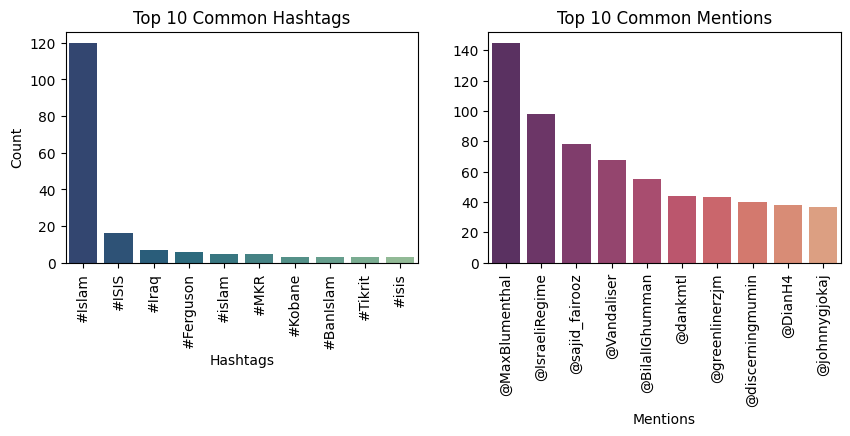

In [17]:
import seaborn as sns
plt.figure(figsize=(10, 3))
plt.subplot(121)
sns.barplot(x='Label', y='Count', data=racist_hashtags.head(10), palette='crest_r')
plt.title('Top 10 Common Hashtags')
plt.xlabel('Hashtags')
plt.ylabel('Count')
plt.xticks(rotation=90)


plt.subplot(122)
sns.barplot(x='Label', y='Count', data=racist_mentions.head(10), palette='flare_r')
plt.title('Top 10 Common Mentions')
plt.xlabel('Mentions')
plt.ylabel('')
plt.xticks(rotation=90)

plt.show()

# Modelling

**Random Forest Classifier**

In [18]:
#train random forest
tfid = TfidfVectorizer()
X = tfid.fit_transform(balanced_data['Final_text'].astype('str').values)
Y = balanced_data['oh_label'].values.reshape((len(balanced_data),1))
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y)
rfc = RandomForestClassifier(n_estimators=200, random_state=0, verbose=1)
rfc.fit(Xtrain, Ytrain)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    5.0s


RandomForestClassifier(n_estimators=200, random_state=0, verbose=1)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s


              precision    recall  f1-score   support

           0       0.89      0.87      0.88       500
           1       0.87      0.89      0.88       485

    accuracy                           0.88       985
   macro avg       0.88      0.88      0.88       985
weighted avg       0.88      0.88      0.88       985

Accuracy of random forest classifier is : 87.9188%


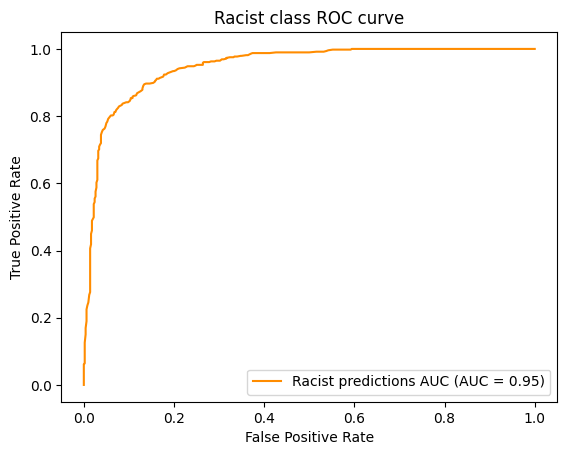

In [19]:
#evaluate random forest
from sklearn import metrics
rfc_preds = rfc.predict(Xtest)
probs = rfc.predict_proba(Xtest)
print(metrics.classification_report(Ytest, rfc_preds))
acc = round(metrics.accuracy_score(Ytest, rfc_preds)*100,4)
print(f"Accuracy of random forest classifier is : {acc}%")
Yonehot = one_hot(Ytest)
class_id = np.flatnonzero(rfc.classes_ == 1)[0]
display = metrics.RocCurveDisplay.from_predictions(
    Yonehot[:, class_id],
    probs[:, class_id],
    name=f"Racist predictions AUC",
    color="darkorange",
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Racist class ROC curve",
)

**CatBoost Classifier**

In [20]:
#train catboost
from catboost import CatBoostClassifier, Pool
dev = 'GPU' if torch.cuda.is_available() else 'CPU'
print(f"Running on {dev}")
cat_model = CatBoostClassifier(task_type=dev)
train_pool = Pool(data=Xtrain, label=Ytrain)
test_pool = Pool(data=Xtest, label=Ytest)
cat_model.fit(train_pool, verbose=100, eval_set=test_pool)

Running on GPU
Learning rate set to 0.064942
0:	learn: 0.6390255	test: 0.6398887	best: 0.6398887 (0)	total: 17.4s	remaining: 4h 50m 32s
100:	learn: 0.2848778	test: 0.3233663	best: 0.3233663 (100)	total: 22s	remaining: 3m 15s
200:	learn: 0.2432156	test: 0.3111529	best: 0.3105839 (196)	total: 26.4s	remaining: 1m 44s
300:	learn: 0.2131229	test: 0.3020479	best: 0.3019371 (298)	total: 30.8s	remaining: 1m 11s
400:	learn: 0.1945332	test: 0.2986595	best: 0.2986129 (394)	total: 35.1s	remaining: 52.5s
500:	learn: 0.1792887	test: 0.2998185	best: 0.2985705 (403)	total: 39.5s	remaining: 39.3s
600:	learn: 0.1685009	test: 0.2989605	best: 0.2985705 (403)	total: 43.8s	remaining: 29.1s
700:	learn: 0.1588563	test: 0.2982601	best: 0.2978786 (684)	total: 48.2s	remaining: 20.5s
800:	learn: 0.1504268	test: 0.2980622	best: 0.2972429 (741)	total: 52.6s	remaining: 13.1s
900:	learn: 0.1422315	test: 0.2982687	best: 0.2972429 (741)	total: 57s	remaining: 6.26s
999:	learn: 0.1362735	test: 0.2991995	best: 0.2972429 (

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       500
           1       0.91      0.83      0.87       485

    accuracy                           0.88       985
   macro avg       0.88      0.87      0.87       985
weighted avg       0.88      0.88      0.87       985

Accuracy of catboost classifier is : 87.5127%


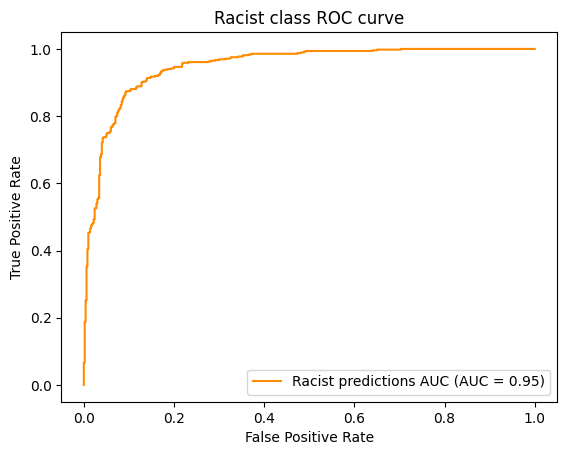

In [21]:
#evaluate catboost
cat_preds = cat_model.predict(Xtest)
probs = cat_model.predict_proba(Xtest)
print(metrics.classification_report(Ytest, cat_preds))
acc = round(metrics.accuracy_score(Ytest, cat_preds)*100,4)
print(f"Accuracy of catboost classifier is : {acc}%")
Yonehot = one_hot(Ytest)
display = metrics.RocCurveDisplay.from_predictions(
    Yonehot[:, 1],
    probs[:, 1],
    name=f"Racist predictions AUC",
    color="darkorange",
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Racist class ROC curve",
)

**BERT with ResNet-18**

In [22]:
#Generating tokens and attention masks and token ids
maxlen=224  
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
raw_texts = balanced_data['Text'].astype('str').values
tokens=[]
attention_masks=[]
tokens_ids=[]
for i in range(len(raw_texts)):
    token = bert_tokenizer.tokenize(raw_texts[i])
    token = ['[CLS]']+token+['[SEP]']
    token = token+(['[PAD]']*(maxlen-len(token)))
    attention_mask = [1 if i!='[PAD]' else 0 for i in token]
    token_ids=bert_tokenizer.convert_tokens_to_ids(token)
    tokens.append(token)
    attention_masks.append(attention_mask)
    tokens_ids.append(token_ids)
    
tokens = np.array(tokens)
attention_masks = np.array(attention_masks)
tokens_ids = np.array(tokens_ids)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [23]:
#Dataset class
class BertDataset:
    def __init__(self, tokens, ams, labels):
        self.tokens = tokens
        self.ams = ams
        self.labels = labels
        
    def __len__(self):
        return len(self.tokens)
    
    def __getitem__(self, idx):
        token = self.tokens[idx]
        am = self.ams[idx]
        label = self.labels[idx]
        
        return {
            'tid':torch.tensor(token),
            'am' : torch.tensor(am),
            'y':torch.tensor(label).float()
        }

In [24]:
#making datasets and data loaders
labels = balanced_data['oh_label'].values
labels = one_hot(labels)
m = tokens_ids.shape[0]
traintid, valtid, testtid, trainam, valam, testam, trainy, valy, testy = tokens_ids[:int(0.6*m)],tokens_ids[int(0.6*m):int(0.8*m)],tokens_ids[int(0.8*m):],attention_masks[:int(0.6*m)],attention_masks[int(0.6*m):int(0.8*m)],attention_masks[int(0.8*m):],labels[:int(0.6*m)],labels[int(0.6*m):int(0.8*m)],labels[int(0.8*m):]
bert_train_dataset=BertDataset(traintid, trainam, trainy)
bert_val_dataset=BertDataset(valtid, valam, valy)
bert_test_dataset=BertDataset(testtid, testam, testy)

bert_train_loader = torch.utils.data.DataLoader(bert_train_dataset, batch_size=16)
bert_val_loader = torch.utils.data.DataLoader(bert_val_dataset, batch_size=16)
bert_test_loader = torch.utils.data.DataLoader(bert_test_dataset, batch_size=16)

In [25]:
#first model class
class MyModel(nn.Module):
    def __init__(self, model_dim, maxlen, num_words):
        super(MyModel, self).__init__()
        self.dim = model_dim
        self.maxlen = maxlen
        self.embed = nn.Embedding(num_words, model_dim)
        
        layers = [nn.Flatten(start_dim=1, end_dim=-1),
                  #nn.Dropout(p=0.2, inplace=True),
                 nn.Linear(model_dim*maxlen, 2),
                 ]
        self.model = nn.Sequential(*layers)
        self.sig = nn.Softmax(1)
        
    def forward(self, x):
        embedd = self.embed(x)
       # print(embedd.shape)
        out = self.sig(self.model(embedd))
        return out

In [26]:
#another model architecture
import timm
class ConvModel(nn.Module):
    def __init__(self, model_dim, bert_model, model_name):
        super(ConvModel, self).__init__()
        self.model_dim = model_dim
        self.bm = bert_model
        self.conv = nn.Conv2d(1,3,(1,545),stride=1,padding=0)
        #self.drop = nn.Dropout(p=0.5)
        self.model = timm.create_model(model_name,
                                      pretrained=True, num_classes=2)
        self.soft = nn.Softmax(dim=1)
        
    def forward(self, x):
        tid, am = x[0], x[1]
        embed = self.bm(tid, attention_mask=am)[0]
        #shape -> (bs, 224, 768)
        embed = embed.reshape((embed.shape[0],1,embed.shape[1],embed.shape[2]))
        #shape -> (bs, 1, 224, 768)
        im = self.conv(embed)
        #shape -> (bs, 3, 224, 224)
        out = self.model(im)
        out = self.soft(out)
        return out

In [27]:
#trainer and validator functions
from tqdm.auto import tqdm
def bert_trainer(train_loader, model, optimizer, criterion, device):
    model.to(device).train()
    it_loss = 0
    counter=0
    
    for i, data in enumerate(tqdm(train_loader,total = len(train_loader))):
        optimizer.zero_grad()
        tids = data['tid'].to(device)
        ams = data['am'].to(device)
        labels = data['y'].to(device).float()
        outs = model((tids, ams))
        loss = criterion(outs, labels)
        loss.backward()
        optimizer.step()
        it_loss += loss.item()*tids.shape[0]
        counter += tids.shape[0]
        
    return it_loss/counter

def bert_validator(test_loader, model, criterion, device):
    model.to(device).eval()
    it_loss=0
    counter=0
    
    for i, data in enumerate(tqdm(test_loader,total = len(test_loader))):
        tids = data['tid'].to(device)
        ams = data['am'].to(device)
        labels = data['y'].to(device).float()
        with torch.no_grad():
            outs = model((tids, ams))
            loss = criterion(outs, labels)
            it_loss += loss.item()*tids.shape[0]
            counter += tids.shape[0]
            
    return it_loss/counter

In [28]:
from tqdm.auto import tqdm
def trainer(train_loader, model, optimizer, criterion, device):
    model.to(device).train()
    it_loss = 0
    counter=0
    
    for i, data in enumerate(tqdm(train_loader,total = len(train_loader))):
        optimizer.zero_grad()
        texts = data['x'].to(device)
        labels = data['y'].to(device)
        outs = model(texts)
        #labels = labels.reshape((labels.shape[0], 1))
        loss = criterion(outs, labels)
        loss.backward()
        optimizer.step()
        
        it_loss += loss.item()*texts.shape[0]
        counter += texts.shape[0]
        
    return it_loss/counter

def validator(test_loader, model, criterion, device):
    model.to(device).eval()
    it_loss=0
    counter=0
    
    for i, data in enumerate(tqdm(test_loader,total = len(test_loader))):
        texts = data['x'].to(device)
        labels = data['y'].to(device)
        #labels = labels.reshape((labels.shape[0], 1))
        with torch.no_grad():
            outs = model(texts)
            loss = criterion(outs, labels)
            it_loss += loss.item()*texts.shape[0]
            counter += texts.shape[0]
            
    return it_loss/counter

In [29]:
#loading model
import warnings
warnings.filterwarnings('ignore')
model_dim = 768
num_words = 30_000
conv_model = ConvModel(model_dim, bert_model, 'resnet18')

#using previously trained model from version 1 of notebook
check_point = torch.load(cyberbullying_path+"Bestmodel.model") 
conv_model.load_state_dict(check_point['model'])

epochs=10
lr=1e-5
optimizer = torch.optim.RAdam(conv_model.parameters(), lr=lr)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer)
print(f"Running on {device}\n")
#conv_model.bm.embeddings = conv_model.bm.embeddings.requires_grad_(False)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Running on cuda



In [30]:
#training loop
train_losses=[]
test_losses=[]
best_loss = np.inf
for epoch in range(epochs):
    print(f"\nBegan iteration {epoch+1}")
    train_loss = bert_trainer(bert_train_loader, conv_model, optimizer, criterion, device)
    val_loss = bert_validator(bert_val_loader, conv_model, criterion, device)
    train_losses.append(train_loss)
    test_losses.append(val_loss)
    scheduler.step(val_loss)
    print(f'Validation Loss : {val_loss}')
    if val_loss<best_loss:
        best_loss = val_loss
        dic={
            'model':conv_model.state_dict()
        }
        torch.save(dic, "./Bestmodel.model")
        print("Improved and saved the model")
    


Began iteration 1


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validation Loss : 0.3475666990134922
Improved and saved the model

Began iteration 2


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validation Loss : 0.28191594257572583
Improved and saved the model

Began iteration 3


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validation Loss : 0.2892311160939599

Began iteration 4


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validation Loss : 0.25568129341614426
Improved and saved the model

Began iteration 5


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validation Loss : 0.24507524458890034
Improved and saved the model

Began iteration 6


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validation Loss : 0.22688003224769826
Improved and saved the model

Began iteration 7


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validation Loss : 0.23411844572440016

Began iteration 8


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validation Loss : 0.24426862960539494

Began iteration 9


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validation Loss : 0.25319350870127605

Began iteration 10


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Validation Loss : 0.2817213243336847


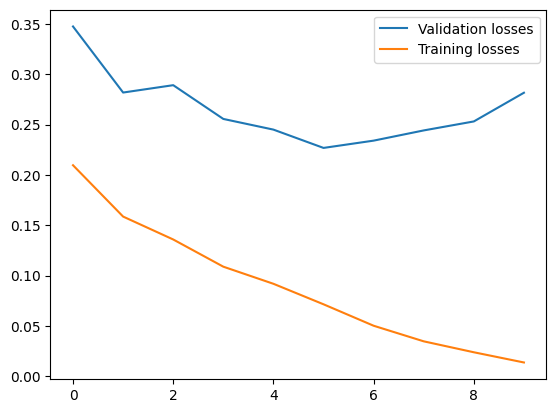

In [31]:
#visualize training 
plt.plot(range(len(test_losses)), test_losses, label = 'Validation losses')
plt.plot(range(len(train_losses)), train_losses, label = 'Training losses')
plt.legend()
plt.show()

In [32]:
#tester function for test data loaders
def tester(model, test_loader, device):
    model.to(device).eval()
    preds=[]
    Ytrue = []
    for i, data in enumerate(tqdm(test_loader,total = len(test_loader))):
        inps = data['x'].to(device)
        labels = data['y'].to(device)
        
        with torch.no_grad():
            out = model(inps)
            preds.append(out.softmax(1).detach().cpu().numpy())
            Ytrue.append(labels.cpu())
            
    preds = np.concatenate(preds)
    preds = preds.argmax(1)
    Ytrue = np.concatenate(Ytrue)
    Ytrue = Ytrue.argmax(1)
    
    return preds, Ytrue

def bert_tester(model, test_loader, device):
    model.to(device).eval()
    preds=[]
    Ytrue = []
    for i, data in enumerate(tqdm(test_loader,total = len(test_loader))):
        tids = data['tid'].to(device)
        ams = data['am'].to(device)
        labels = data['y'].to(device)
        
        with torch.no_grad():
            out = model((tids, ams))
            preds.append(out.detach().cpu().numpy())
            Ytrue.append(labels.cpu())
            
    preds = np.concatenate(preds)
    probs = preds
    preds = preds.argmax(1)
    Ytrue = np.concatenate(Ytrue)
    Ytrue = Ytrue.argmax(1)
    
    return probs, preds, Ytrue

In [33]:
#load best state of model
check_point = torch.load("./Bestmodel.model")
conv_model.load_state_dict(check_point['model'])
conv_probs, preds, Ytrue = bert_tester(conv_model, bert_test_loader, device)


  0%|          | 0/50 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       372
           1       0.94      0.96      0.95       416

    accuracy                           0.95       788
   macro avg       0.95      0.95      0.95       788
weighted avg       0.95      0.95      0.95       788


Accuracy of the model is : 94.797%



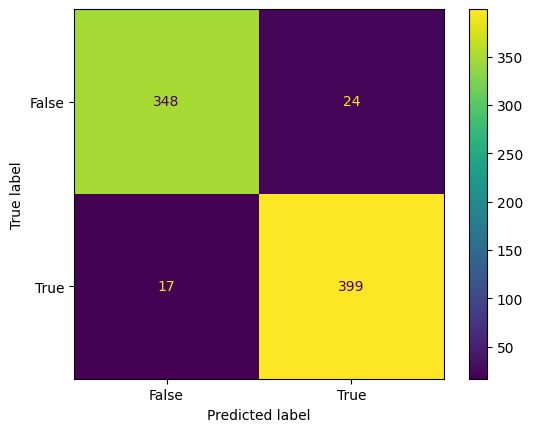

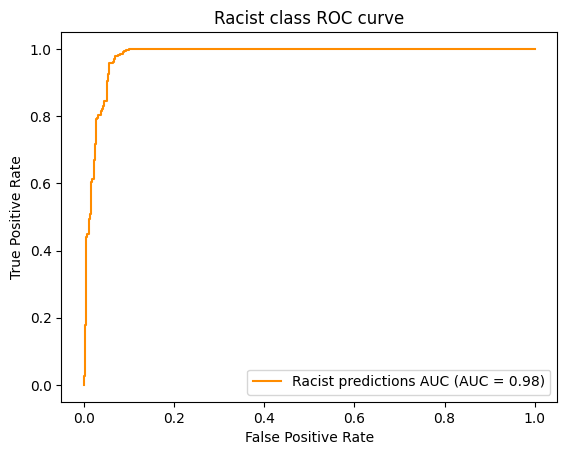

In [34]:
#metrics
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(Ytrue, preds)
print(metrics.classification_report(Ytrue, preds))
print(f"\nAccuracy of the model is : {round(metrics.accuracy_score(Ytrue, preds)*100,4)}%\n")
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
Yonehot = one_hot(Ytrue)
display = metrics.RocCurveDisplay.from_predictions(
    Yonehot[:, 1],
    conv_probs[:, 1],
    name=f"Racist predictions AUC",
    color="darkorange",
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Racist class ROC curve",
)


In [35]:
#EOF